In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc as pm
from palmerpenguins import load_penguins
print(pm.__version__)

4.0.0b6


In [6]:
penguins = load_penguins()
penguins.dropna(how='any', axis=0, inplace=True)

In [7]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [11]:
adelie_mask = (penguins['species'] == 'Adelie')
adelie_flipper_obs = penguins.loc[adelie_mask, 'flipper_length_mm'].values
adelie_mass_obs = penguins.loc[adelie_mask, 'body_mass_g'].values

In [13]:
with pm.Model() as adelie_flipper_model:
    
    adelie_flipper_length = pm.Data('adelie_flipper_length', adelie_flipper_obs)

    sigma = pm.HalfStudentT('sigma', 100, 2000)
    b_0 = pm.Normal('b_0', 0, 4000)
    b_1 = pm.Normal('b_1', 0, 4000)
    mu = pm.Deterministic('mu', b_0 + b_1 * adelie_flipper_length)

    mass = pm.Normal('mass', mu=mu, sigma=sigma, observed=adelie_mass_obs)

    adelie_flipper_regression = pm.sample(return_inferencedata=True)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/pymc/data.py:647: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversi

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


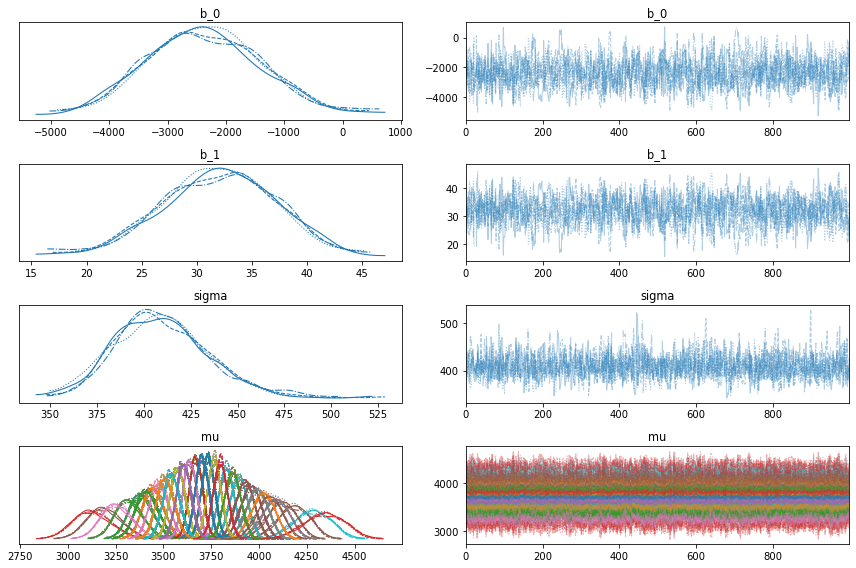

In [17]:
az.plot_trace(adelie_flipper_regression)
plt.tight_layout()
plt.show()

In [ ]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

In [ ]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
                             
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)

    # --> 

    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}